In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize']=[16,9]

In [2]:
class Team:
    def __init__(self,name='poop FC',lmbd0=1,tau0=0.1):
        self.name=name
        self.lmbd0=lmbd0
        self.tau0=tau0
        self.lmbd_set=np.linspace(0,10,1001)
        self.p=self.lmbd_set*0+1
        self.p=self.p/self.p.sum()
        self.tau_set=np.linspace(0,10,1001)
        self.q=self.tau_set*0+1
        self.q=self.q/self.q.sum()
    def sim_1(self,other_team):
        lH=self.lmbd0+other_team.tau0
        lA=self.tau0+other_team.lmbd0
        gH=np.random.poisson(lH)
        gA=np.random.poisson(lA)
        return gH,gA
    def plt(self):
        plt.plot(self.lmbd_set,self.p,label=self.name+' lmbda')
        plt.plot(self.tau_set,self.q,label=self.name+' tau')
        plt.legend()
        plt.grid(True)
        l,t=self.means()
        plt.title('lambda: {:0.2f} tau: {:0.2f}'.format(l,t))
    def means(self):
        return self.p.dot(self.lmbd_set),self.q.dot(self.tau_set)
    def simplify(self,threshold=1e-10):
        ind=self.p>threshold
        self.lmbd_set=self.lmbd_set[ind]
        self.p=self.p[ind]
        self.p=self.p/self.p.sum()
        ind=self.q>threshold
        self.tau_set=self.tau_set[ind]
        self.q=self.q[ind]
        self.q=self.q/self.q.sum()
    def vs(self,other_team,n=int(1e4)):
        lH=np.random.choice(self.lmbd_set,size=n,p=self.p)+np.random.choice(other_team.tau_set,size=n,p=other_team.q)
        gH=np.random.poisson(lH)
        lA=np.random.choice(self.tau_set,size=n,p=self.q)+np.random.choice(other_team.lmbd_set,size=n,p=other_team.p)
        gA=np.random.poisson(lA)
        match_des=self.name + ' vs ' + other_team.name
        return gH,gA,match_des

def evolve(p,q,lmbd,tau,k):
    lmb_plus_tau=lmbd+tau[:,np.newaxis]
    new_p=((np.exp(-lmb_plus_tau)*(lmb_plus_tau**k)).T*q).sum(axis=1)*p
    new_p=new_p/new_p.sum()
    new_q=((np.exp(-lmb_plus_tau)*(lmb_plus_tau**k))*p).sum(axis=1)*q
    new_q=new_q/new_q.sum()
    return new_p,new_q



In [3]:
df=pd.read_csv('http://www.football-data.co.uk/mmz4281/1718/E0.csv' )

In [4]:
team_names=['Man United']
teams=dict()
teams['Man United']=Team('Man United')
for index, row in df.iterrows():
    if row['HomeTeam'] not in team_names:
        team_names.append(row['HomeTeam'])
        teams[row['HomeTeam']]=Team(name=row['HomeTeam'])
    if row['AwayTeam'] not in team_names:
        team_names.append(row['AwayTeam'])
        teams[row['AwayTeam']]=Team(name=row['AwayTeam'])
    gH=row['FTHG']
    gA=row['FTAG']
    team1=teams[row['HomeTeam']]
    team2=teams[row['AwayTeam']]
    team1.p,team2.q=evolve(team1.p,team2.q,team1.lmbd_set,team2.tau_set,gH)
    team2.p,team1.q=evolve(team2.p,team1.q,team2.lmbd_set,team1.tau_set,gA)

In [5]:
for _t in teams:
    teams[_t].simplify()

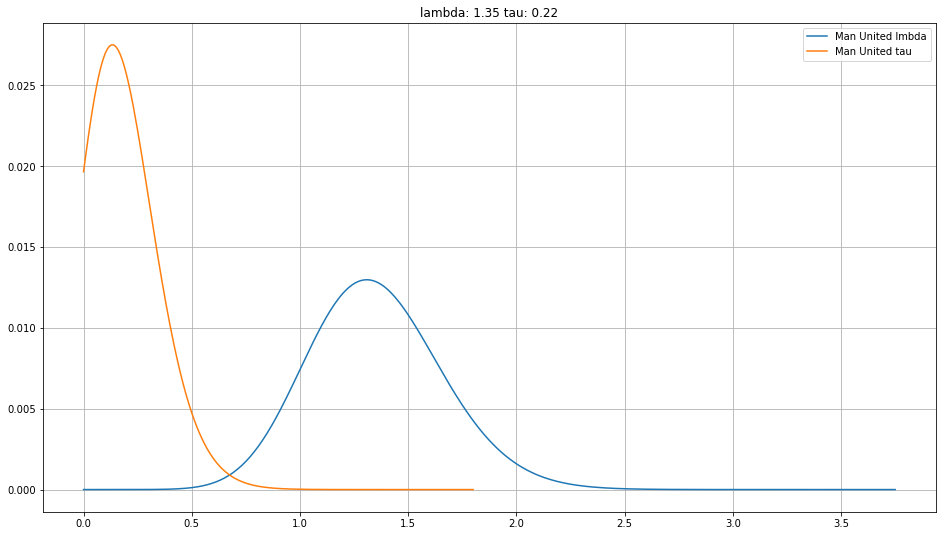

In [6]:
teams['Man United'].plt()

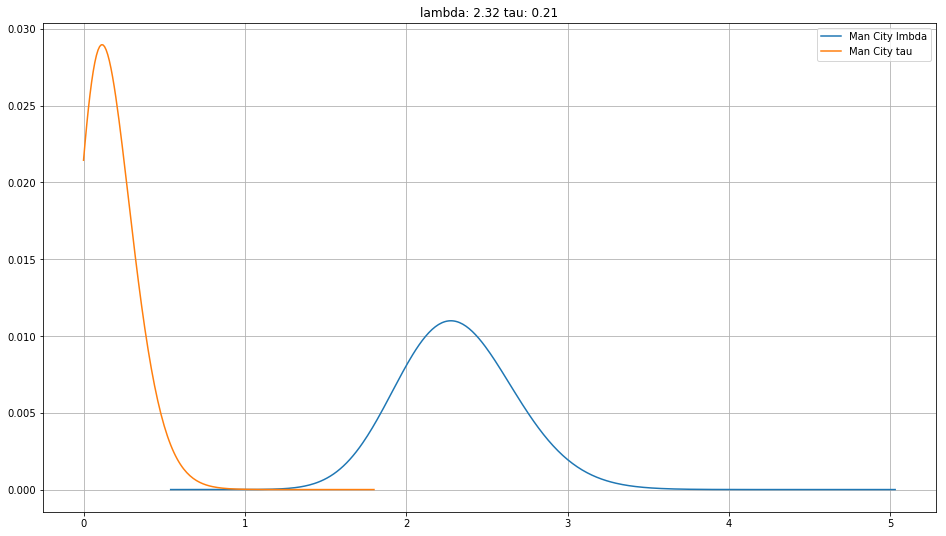

In [7]:
teams['Man City'].plt()

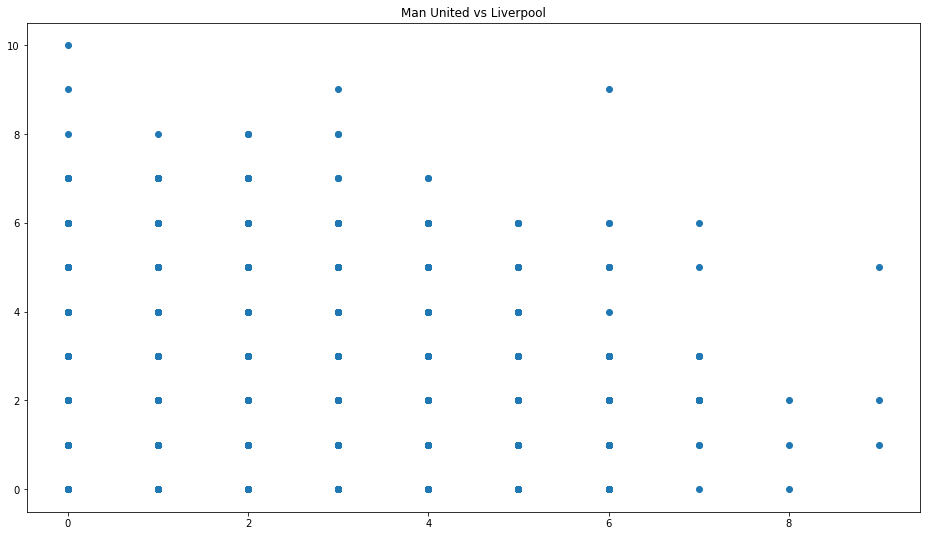

In [10]:
team1=teams['Man United']
team2=teams['Liverpool']
gH,gA,match_des=team1.vs(team2)
plt.scatter(gH,gA)
plt.title(match_des)